# 4. テキストを生成するための GPT モデルを一から実装する

## 4.1 LLM アーキテクチャのコーディング

In [1]:
GPT_CONFIG_124M = {
  "vocab_size": 50257,
  "context_length": 1024,
  "emb_dim": 768,
  "n_heads": 12,
  "n_layers": 12,
  "drop_rate": 0.1,
  "qkv_bias": False
}

In [2]:
# GPT プレースホルダモデルアーキテクチャ

import torch
import torch.nn as nn 

class DummyGPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
      *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds 
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):

  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNorm(nn.Module):

  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x





In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every ca holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1275, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.9173, -0.0155, -0.6105,  ..., -0.1469,  0.5769,  0.9549],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 層正規化を使って活性化を正規化する

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n:", mean)
print("Variance:\n", var)

Mean:
: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [8]:
# 層正規化クラス

class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift 
  

In [9]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n",var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 4.3 GELU活性化を使ってフィードフォワードネットワークを実装する

In [10]:
# GELU活性化関数
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi))* (x + 0.044715 * torch.pow(x, 3))))

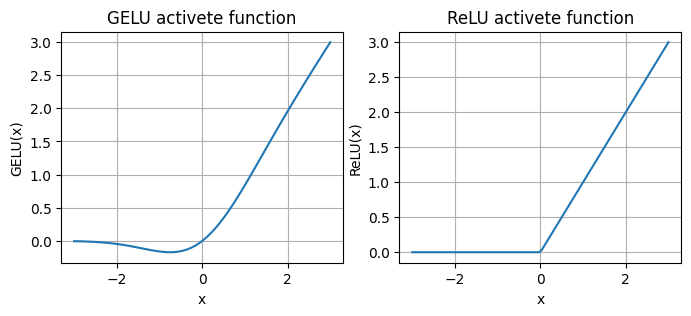

In [11]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activete function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout
plt.show()

In [12]:
# フィードフォワードニューラルネットワークモジュール

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
      GELU(),
      nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self, x):
    return self.layers(x)

In [13]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## 4.4 ショートカット接続を追加する

In [14]:
# list 4.5 ショートカット接続を追加したニューラルネットワーク

class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut

    self.layers = nn.ModuleList([
      nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
      nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x




In [15]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [16]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [17]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


## 4.5 Transformer ブロックで Attention 層と線形層を接続する

In [18]:
# list 4-6 

from MultiHeadAttention import MultiHeadAttention

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
      d_in=cfg["emb_dim"], d_out=cfg["emb_dim"], context_length=cfg["context_length"],
      num_heads=cfg["n_heads"], dropout=cfg["drop_rate"], qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x 

In [19]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 4.6 GTP モデルを実装する

In [20]:
# List 4-7

class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
      *[TransformerBlock(cfg) for _ in range (cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits
                        


In [21]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1275, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.5808, -0.3684, -0.8953,  ...,  0.2689,  0.3532, -0.2765],
         [ 0.6849,  0.5518, -0.4592,  ...,  0.5692,  0.1969, -0.0337],
         [-0.1738,  0.0315,  0.3711,  ...,  1.1753, -0.4986,  0.0338]]],
       grad_fn=<UnsafeViewBackward0>)


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters : {total_params:,}")

Total number of parameters : 163,009,536


In [25]:
total_params_gtp2 = (
  total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Number of traineable parameters considering weight tying : {total_params_gtp2:,}")

Number of traineable parameters considering weight tying : 124,412,160


In [26]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model] {total_size_mb:.2f} MB")

Total size of the model] 621.83 MB


## 4.7 テキストを生成する

In [35]:
# List 4-8

def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [36]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [38]:
model.eval() # dropout 無効化

out = generate_text_simple(
  model=model,
  idx=encoded_tensor,
  max_new_tokens=6,
  context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [39]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
